In [2]:
pip install pystan


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()  # Nice plot aesthetic
np.random.seed(101)

model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""


INFO:numexpr.utils:NumExpr defaulting to 6 threads.


In [4]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

In [5]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.


In [6]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

In [7]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

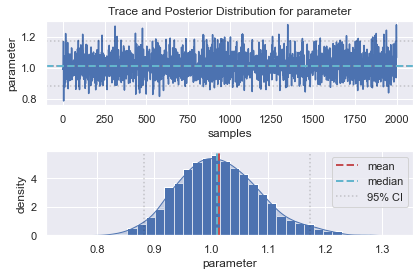

In [8]:
plot_trace(sigma)

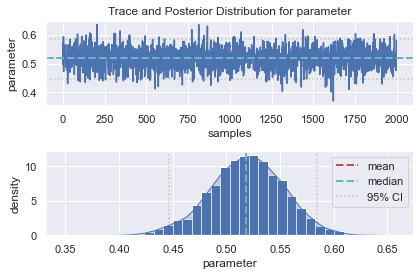

In [9]:
plot_trace(beta)

In [10]:
import pystan
import pickle
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as statmod
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

C:\Users\Usuario\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

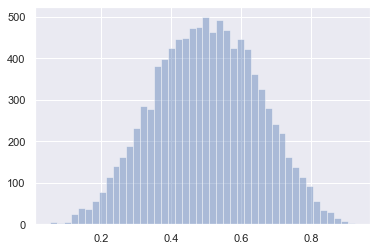

In [11]:
sns.distplot(np.random.beta(5,5, size=10000),kde=False)

In [12]:
# bernoulli model
model_code = """
    data {
      int<lower=0> N;
      int<lower=0,upper=1> y[N];
    }
    parameters {
      real<lower=0,upper=1> theta;
    }
    model {
      theta ~ beta(5, 5);
      for (n in 1:N)
          y[n] ~ bernoulli(theta);
    }
    """
data = dict(N=4, y=[0, 0, 0, 0])
model = pystan.StanModel(model_code=model_code)
fit = model.sampling(data=data,iter=4000, chains=4, warmup=1000)
la = fit.extract(permuted=True)  # return a dictionary of arrays
print(fit.stansummary())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d3835c4370ff5e66f1e88bd3eac647ff NOW.


Inference for Stan model: anon_model_d3835c4370ff5e66f1e88bd3eac647ff.
4 chains, each with iter=4000; warmup=1000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.36  1.8e-3   0.12   0.14   0.26   0.35   0.44   0.62   4656    1.0
lp__   -9.64    0.01   0.72 -11.64  -9.82  -9.37  -9.18  -9.13   4387    1.0

Samples were drawn using NUTS at Fri Apr  1 13:26:00 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [15]:
cars_data = pd.read_csv("https://raw.githubusercontent.com/sergiosonline/sergiosonline.github.io/master/files/cars.csv").set_index("name")
print(cars_data.shape)
cars_data.head()

(392, 8)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,American
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,American
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,American
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,American
ford torino,17.0,8,302.0,140,3449,10.5,70,American


C:\Users\Usuario\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


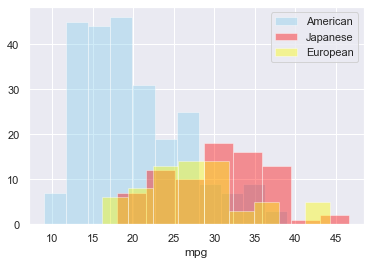

In [16]:
sns.distplot(cars_data[cars_data['origin']=='American']['mpg'],color="skyblue", label="American",kde=False)
sns.distplot(cars_data[cars_data['origin']=='Japanese']['mpg'],color="red", label="Japanese",kde=False)
sns.distplot(cars_data[cars_data['origin']=='European']['mpg'],color="yellow", label="European",kde=False)
plt.legend()

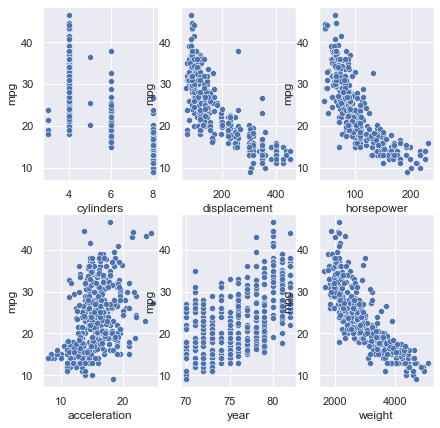

In [21]:
f, axes = plt.subplots(2, 3, figsize=(7, 7), sharex=False)
sns.scatterplot(x="cylinders", y="mpg", data=cars_data, ax=axes[0, 0]);
sns.scatterplot(x="displacement", y="mpg", data=cars_data, ax=axes[0, 1]);
sns.scatterplot(x="horsepower", y="mpg", data=cars_data, ax=axes[0, 2]);
sns.scatterplot(x="acceleration", y="mpg", data=cars_data, ax=axes[1, 0]);
sns.scatterplot(x="year", y="mpg", data=cars_data, ax=axes[1, 1]);
sns.scatterplot(x="weight", y="mpg", data=cars_data, ax=axes[1, 2]);
# close pesky empty plots
for num in range(2,8):
    plt.close(num)
    
plt.show()

In [23]:
from numpy import random
from sklearn import preprocessing, metrics, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
random.seed(12345)
cars_data = cars_data.set_index('name')
y = cars_data['mpg']
X = cars_data.loc[:, cars_data.columns != 'mpg']
X = X.loc[:, X.columns != 'name']
X = pd.get_dummies(X, prefix_sep='_', drop_first=False) 
X = X.drop(columns=["origin_European"]) # This is our reference category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train.head()

KeyError: "None of ['name'] are in the columns"